In [12]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
sys.path.append('../..')

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.misc.data import Data
from magrec import __datapath__

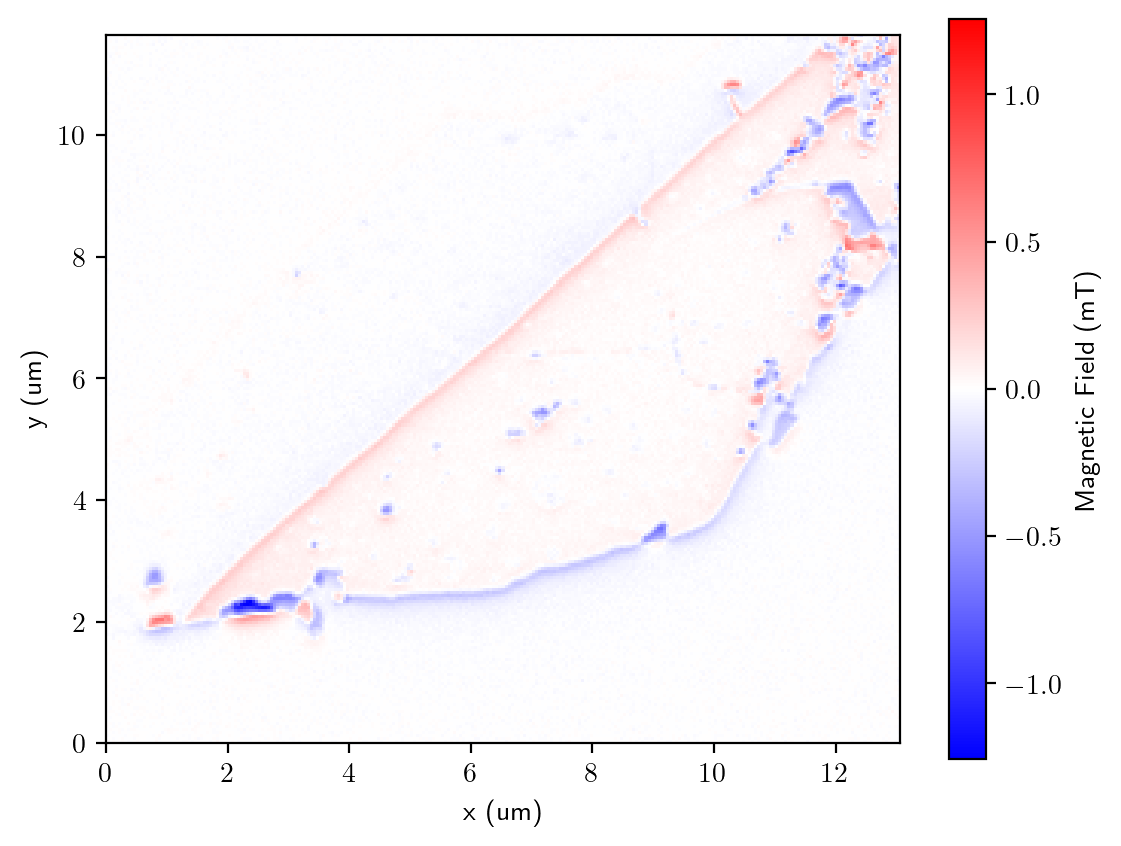

In [15]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

# dataset.define_pixel_size(dx, dy)

sensor_theta = 56
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] - 90 

height =  0.05 # in um


# Create a data class
dataset = Data()
# Load the data to the data class
dataset.load_data(BNV, dx, dy, height, sensor_theta, sensor_phi, 0)

# add filters to the data
dataset.remove_DC_background()


dataset.plot_target()


In [16]:
# Add filter 
dataset.add_hanning_filter(height)
dataset.add_short_wavelength_filter(height)

Applied a high frequency filter, removing all components smaller than 0.05 um


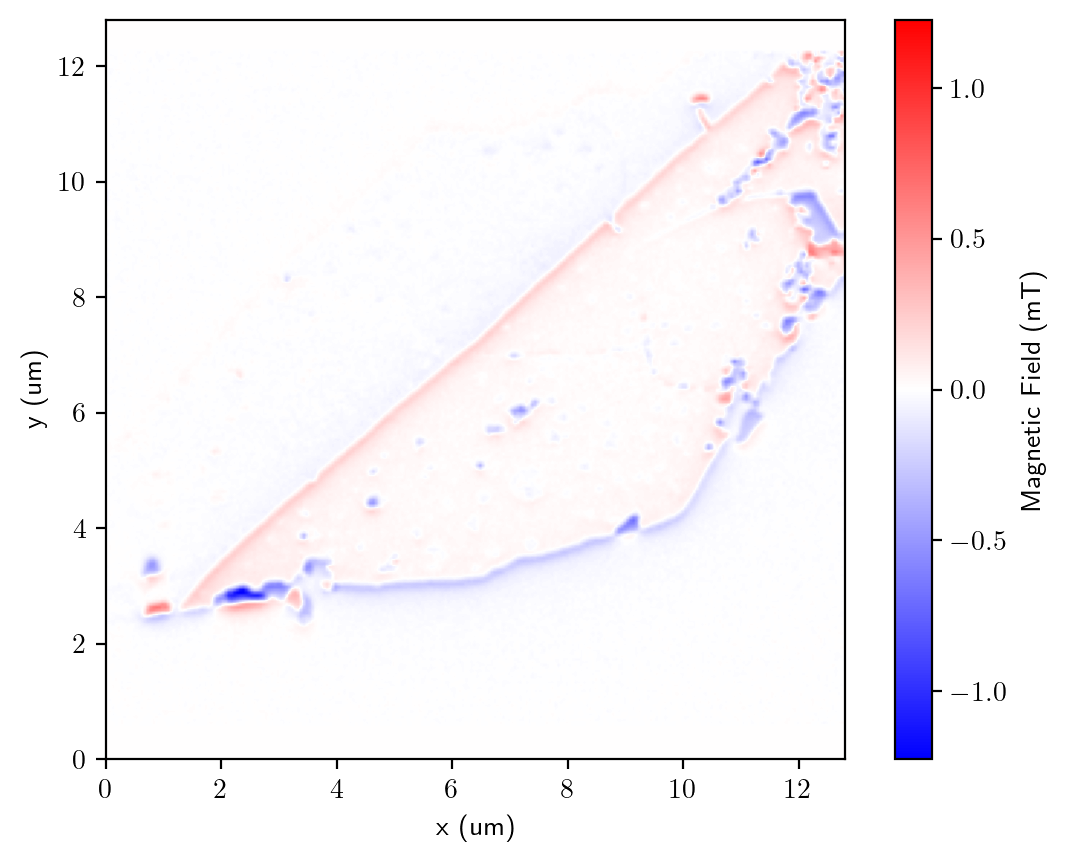

In [17]:
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()
dataset.plot_target()

# Transfor Bsensor into Bxyz

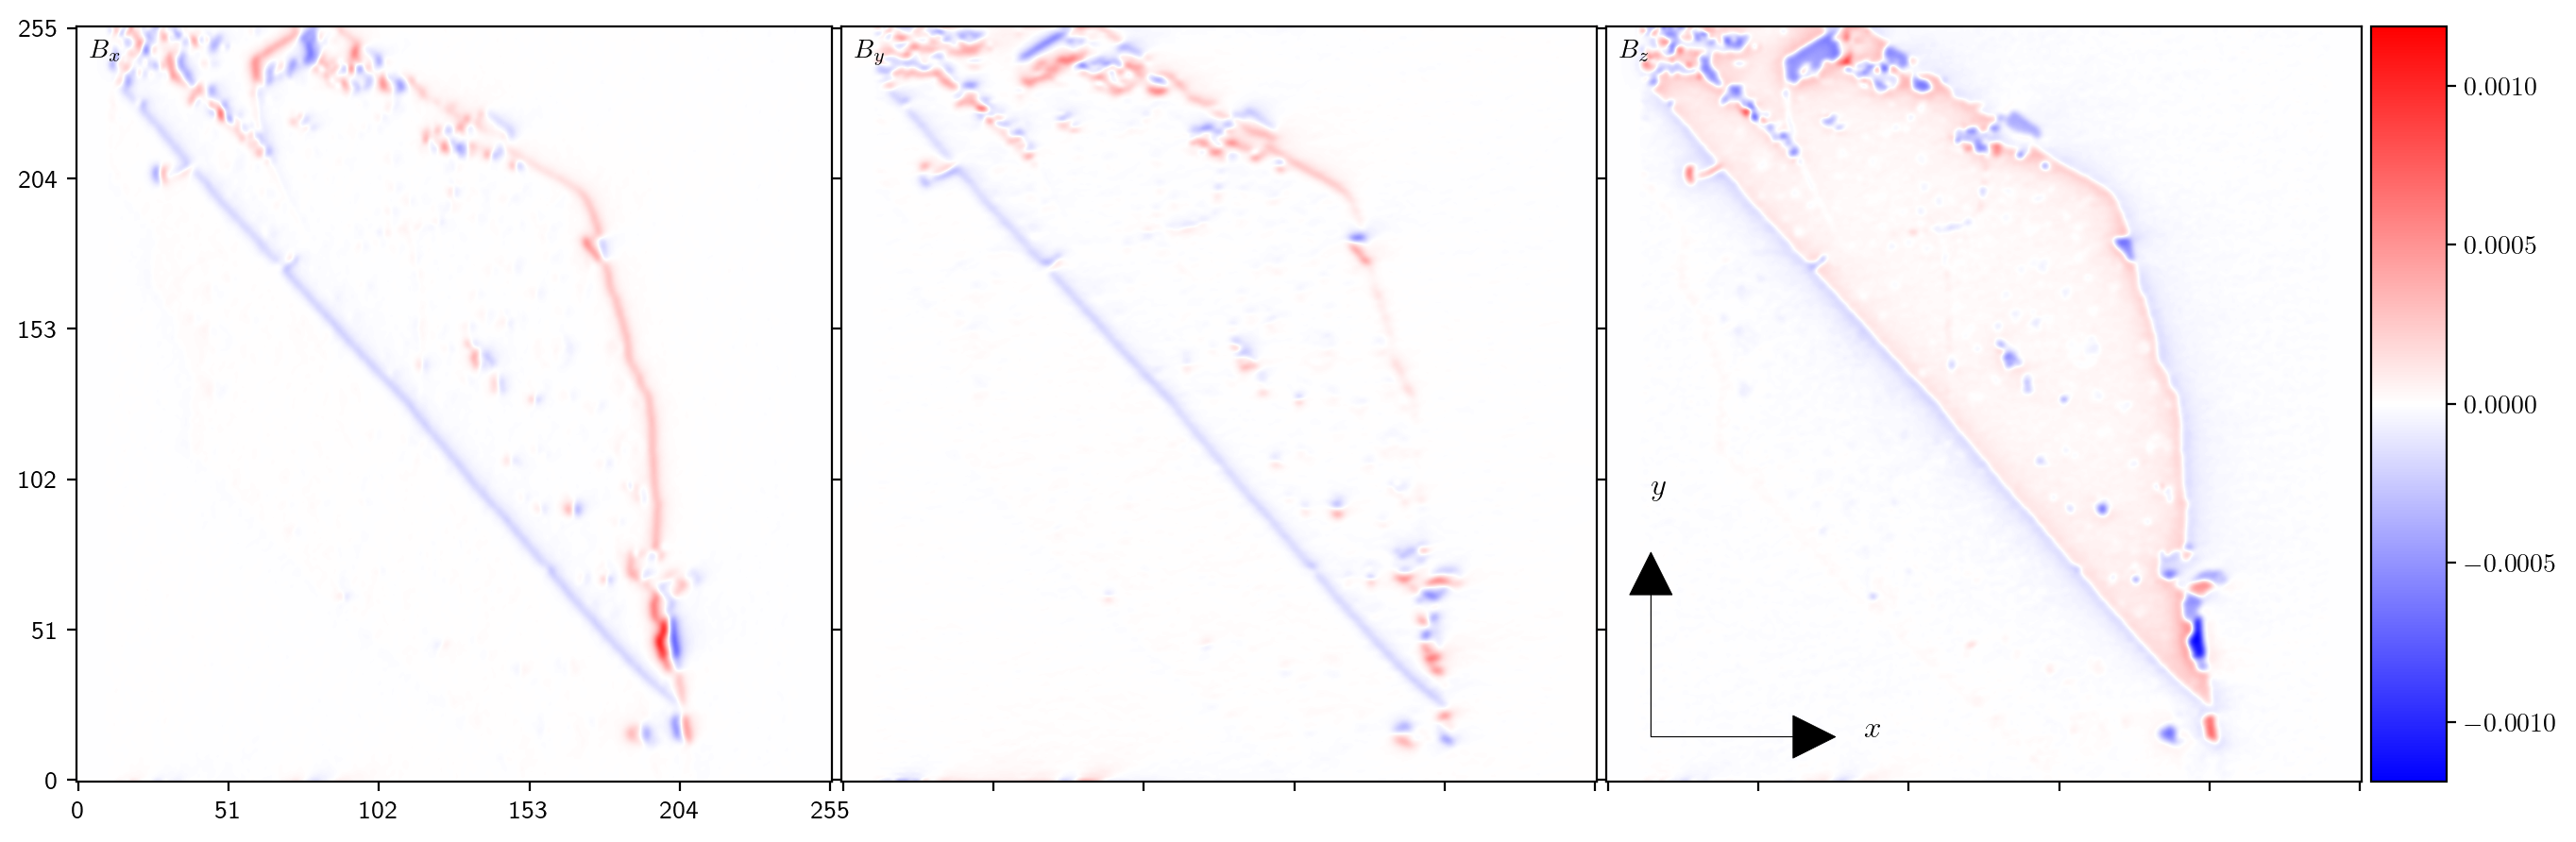

In [18]:
dataset.set_transformer(MagneticFields)
dataset.transform_data()

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

## Reconstruct using only the Bz magnetic field component

Applied a high frequency filter, removing all components smaller than 0.05 um
no input provided, using the dataset target


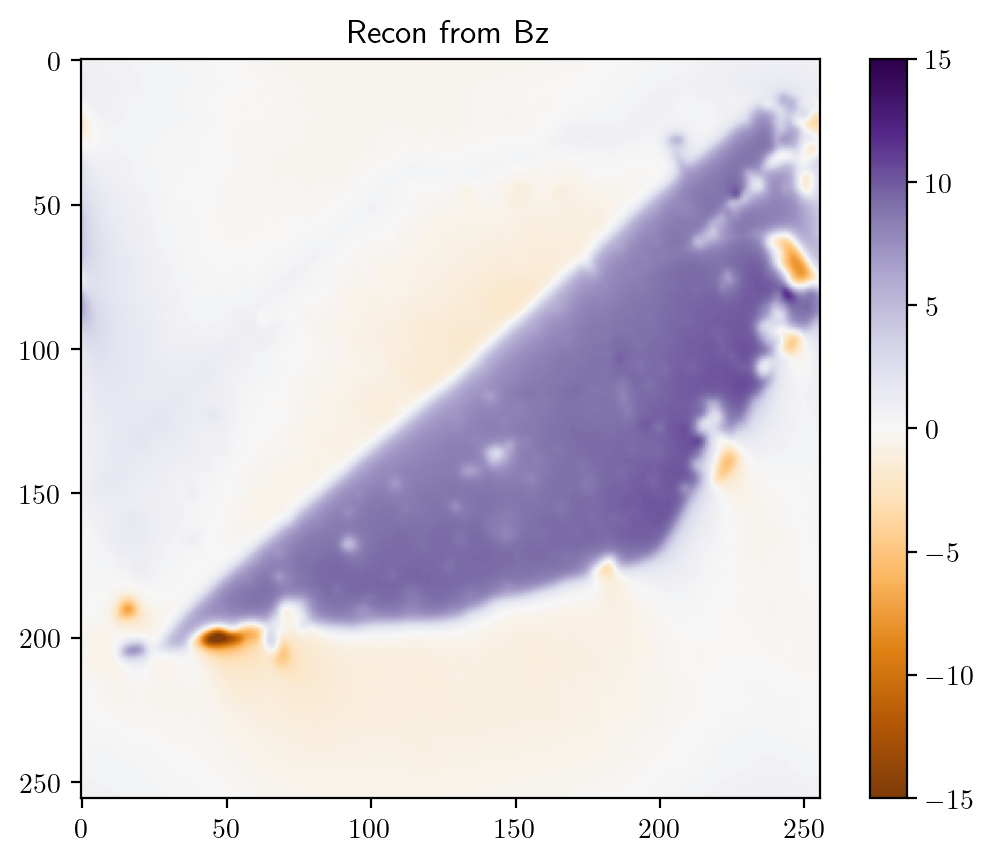

In [40]:
dataset3 = copy.deepcopy(dataset)
dataset3.target = dataset.transformed_target[2,::]
dataset3.define_sensor_angles(0, 0)
dataset3.set_transformer(Bsensor2Mxy, m_theta = 0, m_phi = 0)
dataset3.transform_data()

plt.figure()
plt.imshow(-1*dataset3.transformed_target + 2, cmap="PuOr", vmin=-15, vmax = 15)
plt.title("Recon from Bz")
plt.colorbar()

## Now we will try to reconstruct the magnetisation using a neural network.

In [33]:
from magrec.method.FCNN import FCNN
from magrec.models.UniformMagnetisation import UniformMagnetisation


NN_recon_data = Data()
sensor_theta = 0 
sensor_phi = 0 
NN_recon_data.load_data(dataset.transformed_target[2,::], dx, dy, height, sensor_theta, sensor_phi, 0)

Model = UniformMagnetisation(NN_recon_data, 
                             loss_type = "MSE", 
                             scaling_factor = 1e9, 
                             m_theta = 0, 
                             m_phi = 0, 
                             spatial_filter = True,
                             spatial_filter_width = [0.1, 0.1],
                             source_weight = None,
                             loss_weight = None,  )
FittingMethod = FCNN(Model, learning_rate = 1e-3)


Using a Gaussian filter
Spatial filter implemented into the model with a width of 0.10 and 0.10 pixels or 0.01 um.
Number of sources: 1
Number of targets: 1
Including source angles in the neural network: False


C:\Users\parax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [34]:
FittingMethod.fit(n_epochs=300)

epoch     1 | loss on last mini-batch:  5.86e+09
epoch    26 | loss on last mini-batch:  5.84e+09
epoch    51 | loss on last mini-batch:  4.69e+09
epoch    76 | loss on last mini-batch:  2.07e+09
epoch   101 | loss on last mini-batch:  9.99e+08
epoch   126 | loss on last mini-batch:  5.72e+08
epoch   151 | loss on last mini-batch:  3.75e+08
epoch   176 | loss on last mini-batch:  2.72e+08
epoch   201 | loss on last mini-batch:  2.12e+08
epoch   226 | loss on last mini-batch:  1.76e+08
epoch   251 | loss on last mini-batch:  1.52e+08
epoch   276 | loss on last mini-batch:  1.33e+08


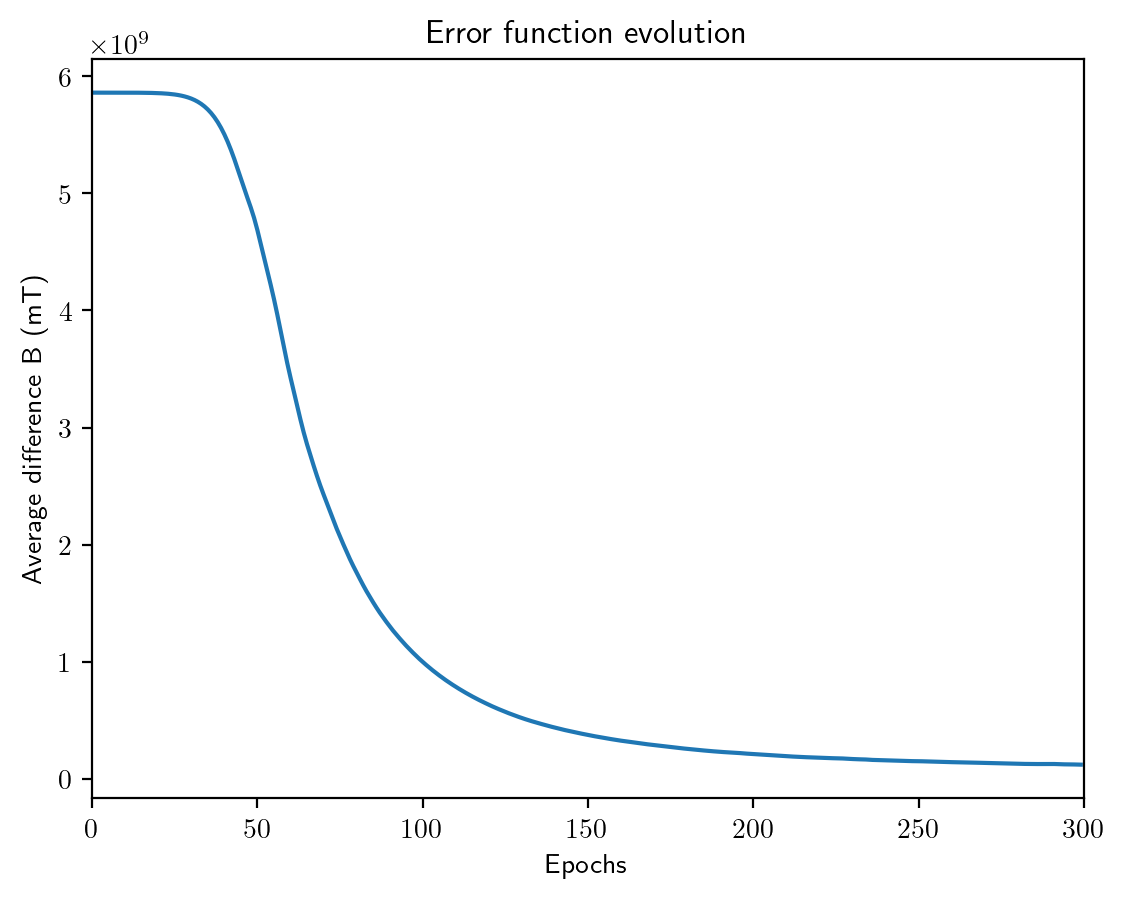

In [35]:
FittingMethod.plot_loss()

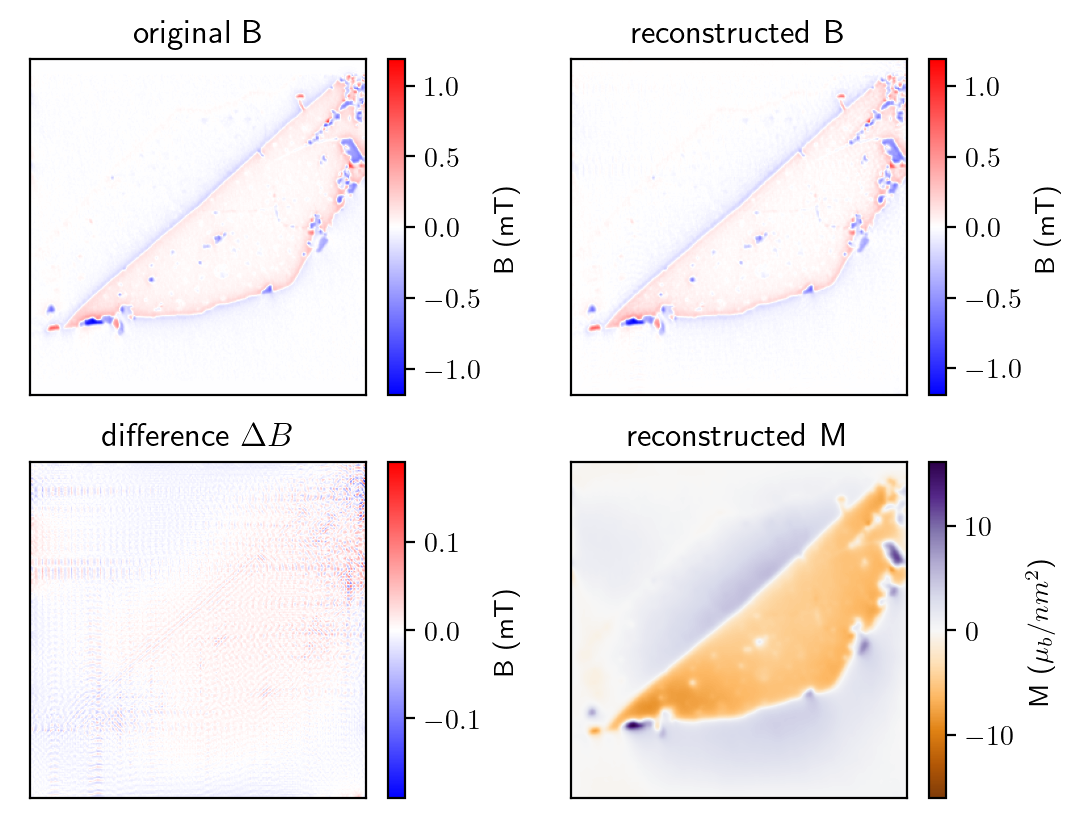

In [37]:
# FittingMethod.extract_results()
FittingMethod.plot_results()

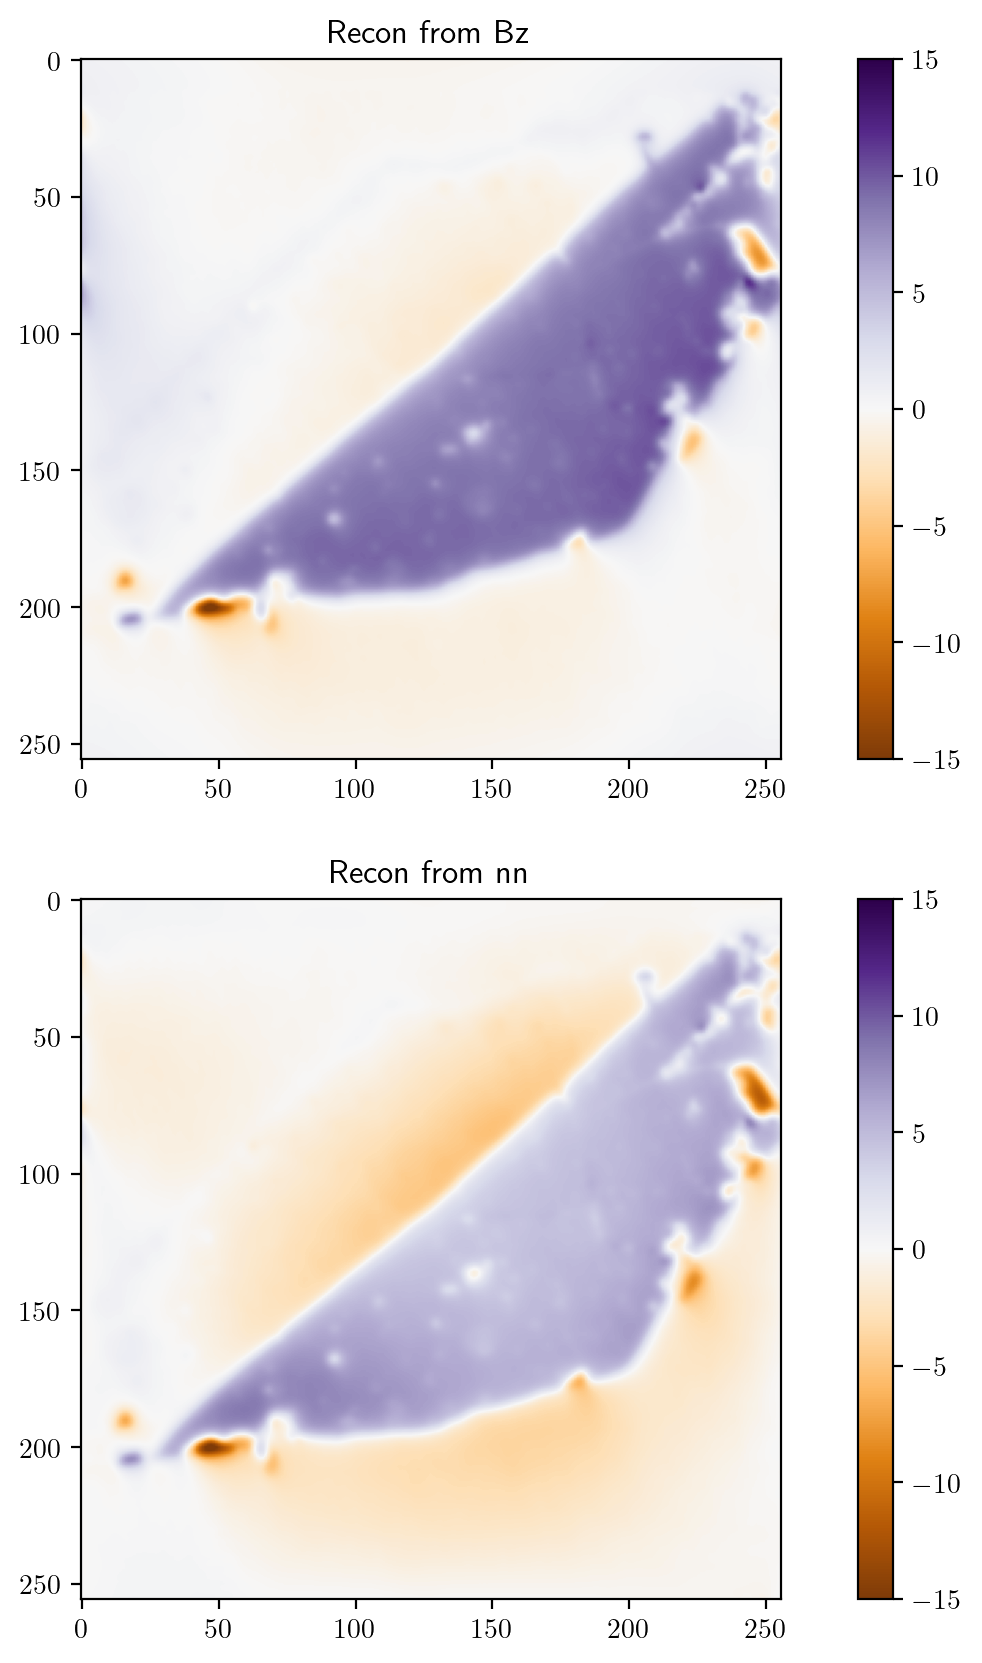

In [48]:

plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.imshow(-1*dataset3.transformed_target + 2, cmap="PuOr", vmin=-15, vmax = 15)
plt.title("Recon from Bz")
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(-1*FittingMethod.results["Magnetisation"] , cmap="PuOr", vmin=-15, vmax = 15)
plt.title("Recon from nn")
plt.colorbar()
